This notebook include all the data in the Bert module

In [ ]:
### Loading data and importing needed package

In [1]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /Users/wuruiling/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuruiling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wuruiling/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("Tweets.csv")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)    
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)    
    return preprocessed_text

In [45]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,retweet_count,text,tweet_created,user_timezone,preprocessed_text
0,5.703060e+17,neutral,1.0000,NaN,NaN,cairdin,0,@TAA What @dhepburn said.,2/24/2015 11:35,Eastern Time (US & Canada),taa dhepburn said
1,5.703010e+17,positive,0.3486,NaN,0.0000,jnardino,0,@TAA plus you've added commercials to the expe...,2/24/2015 11:15,Pacific Time (US & Canada),taa plus added commercial experience tacky
2,5.703010e+17,neutral,0.6837,NaN,NaN,yvonnalynn,0,@TAA I didn't today... Must mean I need to tak...,2/24/2015 11:15,Central Time (US & Canada),taa today must mean need take another trip
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,jnardino,0,@TAA it's really aggressive to blast obnoxious...,2/24/2015 11:15,Pacific Time (US & Canada),taa really aggressive blast obnoxious entertai...
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,jnardino,0,@TAA and it's a really big bad thing about it,2/24/2015 11:14,Pacific Time (US & Canada),taa really big bad thing


In [47]:
print(df.dtypes)

tweet_id                        float64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
name                             object
retweet_count                     int64
text                             object
tweet_created                    object
user_timezone                    object
preprocessed_text                object
dtype: object


In [46]:
print('Total Null Value in the Dataset:')
print(df.isnull().sum())
plt.figure(figsize=(14,8))

Total Null Value in the Dataset:
tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
name                               0
retweet_count                      0
text                               0
tweet_created                      0
user_timezone                   4820
preprocessed_text                  0
dtype: int64


<Figure size 1008x576 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

Reasons of Negative Tweets:
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


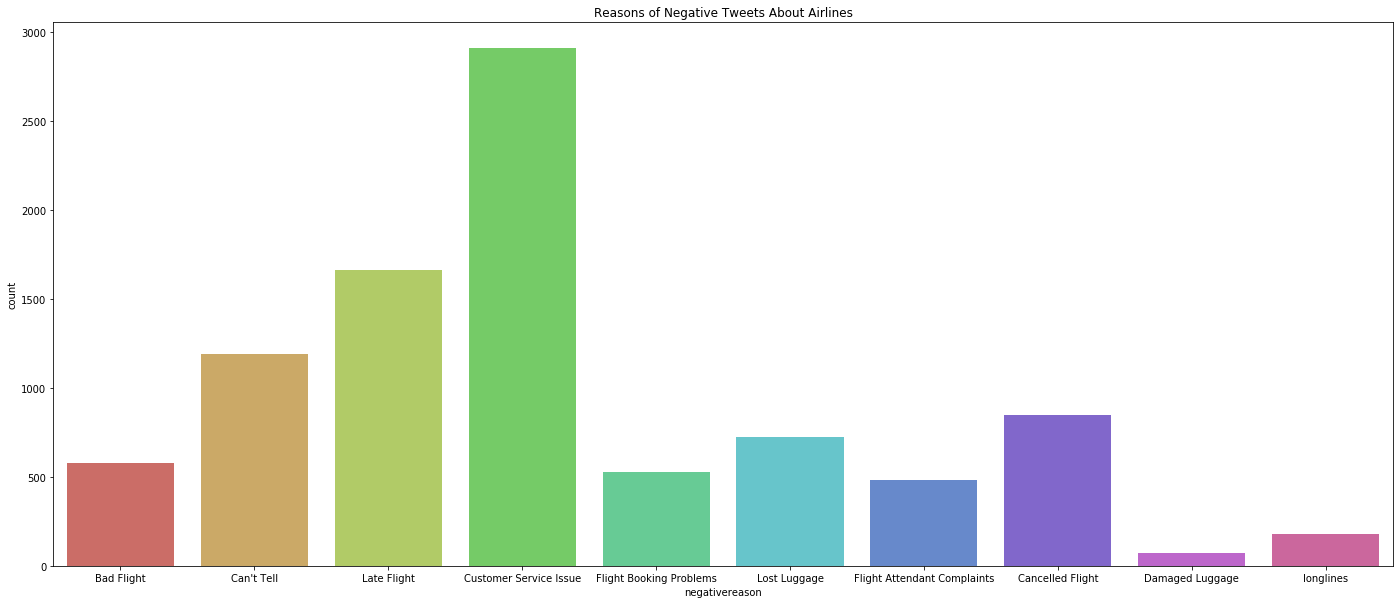

In [48]:
print('Reasons of Negative Tweets:')
print(df.negativereason.value_counts())
plt.figure(figsize=(24,10))
sns.countplot(x='negativereason',data=df, palette='hls')
plt.title('Reasons of Negative Tweets About Airlines')
plt.show()

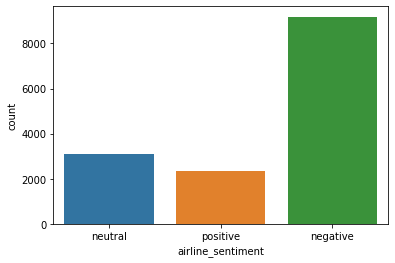

In [3]:
# Unique values of sentiment plot
ax = sns.countplot(x="airline_sentiment", data=df)

### Preprocess Text Data + Splitting into Test sets

In [4]:
# Preprocess the text data
df["preprocessed_text"] = df["text"].apply(preprocess_text)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["preprocessed_text"], df["airline_sentiment"], test_size = 0.2, random_state = 42, stratify = df["airline_sentiment"])

labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

#### Define a function to plot the confusion matrix for ROC-AUC score

In [5]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)
    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_test.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= y_test.shape[1]

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(y_test.shape[1]), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

### Multinomial Naive Bayes

##### Hyperparameter optimization using GridSearchCV (Multinomial Naive Bayes)

In [6]:
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid for alpha
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Initialize the MultinomialNB classifier
nb_classifier = MultinomialNB()

# Define the scoring metric with macro F1 score
scoring = make_scorer(f1_score, average='micro')
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best F1 score: {best_score}")

Best alpha: 0.1
Best F1 score: 0.7434257174650002


##### Train and test the MultinomialNB classifier with the best hyperparameters

In [7]:
# Train the MultinomialNB classifier with the best alpha
best_nb_classifier = MultinomialNB(alpha=best_alpha)
best_nb_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_nb_classifier.predict(X_test_vect)
test_probs = best_nb_classifier.predict_proba(X_test_vect)

# Calculate and print the performance metrics
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate and print the AUC-ROC score
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Test ROC-AUC score:", test_auc)

Test confusion matrix is:
[[1758   50   27]
 [ 357  216   47]
 [ 207   53  213]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1835
           1       0.68      0.35      0.46       620
           2       0.74      0.45      0.56       473

    accuracy                           0.75      2928
   macro avg       0.73      0.59      0.62      2928
weighted avg       0.74      0.75      0.72      2928

Test ROC-AUC score: 0.8698064194020518


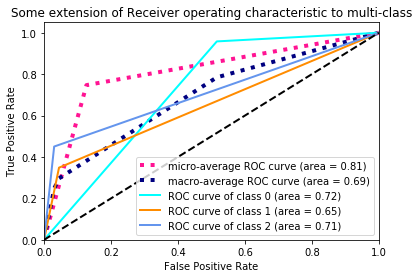

In [8]:
multiclass_roc_auc_score(y_test, predicted_class)

### Logistic Regression

##### Hyperparameter optimization using GridSearchCV (Logistic Regression classifier)

In [9]:
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize the Logistic Regression classifier
log_reg_classifier = LogisticRegression(max_iter=1000)

# Define the scoring metric
scoring = 'f1_macro'  # Using macro F1 score for evaluation

# Initialize GridSearchCV with the classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=log_reg_classifier, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best F1 score: {best_score}")

Best C: 10
Best F1 score: 0.6912724858410495


##### Train and test the Logistic Regression classifier with the best hyperparameters

In [10]:
# Train the Logistic Regression classifier with the best C
best_log_reg_classifier = LogisticRegression(C=best_C, max_iter=1000)
best_log_reg_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_log_reg_classifier.predict(X_test_vect)
test_probs = best_log_reg_classifier.predict_proba(X_test_vect)

# Calculate and print the performance metrics
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate and print the AUC-ROC score
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Test ROC-AUC score:", test_auc)

Test confusion matrix is:
[[1643  137   55]
 [ 247  326   47]
 [  89   95  289]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1835
           1       0.58      0.53      0.55       620
           2       0.74      0.61      0.67       473

    accuracy                           0.77      2928
   macro avg       0.72      0.68      0.69      2928
weighted avg       0.76      0.77      0.77      2928

Test ROC-AUC score: 0.8760510008603112


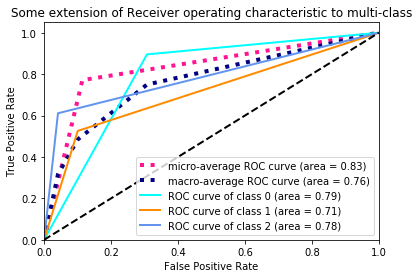

In [11]:
multiclass_roc_auc_score(y_test, predicted_class)

### Random Forest

##### Hyperparameter optimization using GridSearchCV (Random Forest classifier)

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the scoring metric
scoring = 'f1_macro'  # Using macro F1 score for evaluation

# Initialize GridSearchCV with the classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring, cv=5, n_jobs = -1)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 score: 0.6399043434532725


##### Train and test the Random Forest classifier with the best hyperparameters

In [13]:
# Train the Random Forest classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_rf_classifier.predict(X_test_vect)
test_probs = best_rf_classifier.predict_proba(X_test_vect)

# Calculate and print the performance metrics
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate and print the AUC-ROC score
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Test ROC-AUC score:", test_auc)

Test confusion matrix is:
[[1723   78   34]
 [ 319  266   35]
 [ 161   71  241]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1835
           1       0.64      0.43      0.51       620
           2       0.78      0.51      0.62       473

    accuracy                           0.76      2928
   macro avg       0.73      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

Test ROC-AUC score: 0.8665331158778931


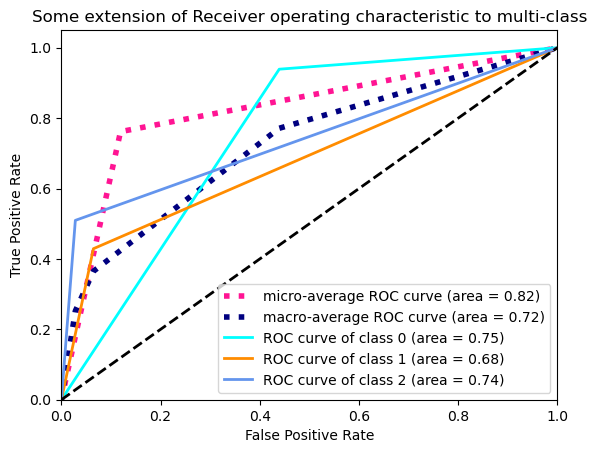

In [14]:
multiclass_roc_auc_score(y_test, predicted_class)

### SVM 

##### Hyperparameter optimization using GridSearchCV (SVM)

In [15]:
from sklearn.svm import SVC

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Define the scoring metric
scoring = 'f1_macro'  # Using macro F1 score for evaluation

# Initialize GridSearchCV with the classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring=scoring, cv=5, n_jobs = -1)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best F1 score: 0.7010676643630902


##### Train and test the SVM with the best hyperparameters

In [16]:
# Train the SVM classifier with the best parameters
best_svm_classifier = SVC(**best_params, probability=True, random_state=42)
best_svm_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_svm_classifier.predict(X_test_vect)
test_probs = best_svm_classifier.predict_proba(X_test_vect)

# Calculate and print the performance metrics
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate and print the AUC-ROC score
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Test ROC-AUC score:", test_auc)

Test confusion matrix is:
[[1686  101   48]
 [ 253  324   43]
 [ 109   74  290]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1835
           1       0.65      0.52      0.58       620
           2       0.76      0.61      0.68       473

    accuracy                           0.79      2928
   macro avg       0.74      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928

Test ROC-AUC score: 0.8918759830985096


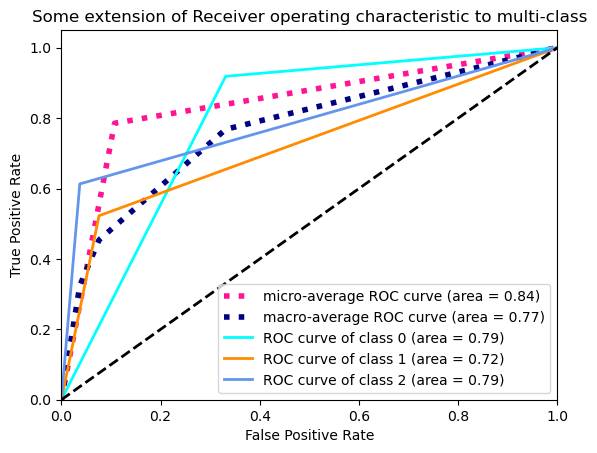

In [17]:
multiclass_roc_auc_score(y_test, predicted_class)

### BERT

In [12]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


The bottom code can be deleted after the code is tested.

In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [14]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Assuming 3 classes for sentiment analysis

# Preprocess the text data
df['preprocessed_text'] = df['text'].apply(preprocess_text)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [15]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Data select to reduce training time, will select 'n' datas per category. n=select_limited_data

In [37]:
import random
select_limited_data = -1
select_pocket = []
select_key = ["negative", "neutral", "positive"]

for select_item in select_key:
    candidate_index = df['airline_sentiment'].isin([select_item])
    target_index = candidate_index.index[candidate_index]
    select_index = random.choices(list(target_index), k=30)
    select_pocket.extend(select_index)
    
if select_limited_data == -1:
    select_df = df
else:
    select_df = df.loc[select_pocket]
    
select_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [38]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(select_df['preprocessed_text'], select_df['airline_sentiment'], test_size=0.2, random_state=42)

In [39]:
def tokenize_and_create_dataloader(texts, labels, batch_size, shuffle):
    # Encode labels into numerical format and convert to torch.int64
    label_encoder = LabelEncoder()
    labels = torch.tensor(label_encoder.fit_transform(labels), dtype=torch.int64)

    # Tokenize input text
    encoded_dict = tokenizer.batch_encode_plus(
        texts,                      
        add_special_tokens = True, 
        max_length = 64,           
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        truncation = True
    )

    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']

    # Create DataLoader
    dataset = TensorDataset(input_ids, attention_masks, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return loader


In [40]:
import numpy as np
def train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        for idx, batch in enumerate(train_loader):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            print("Epoch: {}/{}, Batch: {}/{}".format(epoch+1, num_epochs, idx+1, len(train_loader)))

    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy()
            val_preds.extend(np.argmax(logits, axis=1))
            val_labels.extend(inputs['labels'].detach().cpu().numpy())
            

    train_val_preds = []
    train_val_labels = []

    with torch.no_grad():
        for batch in train_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy()
            train_val_preds.extend(np.argmax(logits, axis=1))
            train_val_labels.extend(inputs['labels'].detach().cpu().numpy())

    accuracy = accuracy_score(val_labels, val_preds)
    print("Accuracy:", accuracy)
    return (val_labels, val_preds), (train_val_preds, train_val_labels)

In [41]:
# Preprocess the text data
#df['preprocessed_text'] = df['text'].apply(preprocess_text)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(select_df['preprocessed_text'], select_df['airline_sentiment'], test_size=0.2, random_state=42)


In [42]:
# Create DataLoader for training and testing data
batch_size = 32
train_loader = tokenize_and_create_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
test_loader = tokenize_and_create_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

/opt/anaconda3/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [44]:
# Train and evaluate the model
(y_test, predicted_class), (y_train, y_train_predict) = train_and_evaluate(model, train_loader, test_loader, num_epochs=3, optimizer=optimizer)

# Add LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Compute AUC-ROC for test set
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        probs = F.softmax(torch.tensor(logits), dim=1).numpy()  
        test_probs.extend(probs)

test_probs = np.array(test_probs)
# Compute AUC-ROC
auc_roc = roc_auc_score(y_test, test_probs, multi_class='ovr')  

# Confusion matrix and classification report
print('Train confusion matrix is: ')
print(confusion_matrix(y_train, y_train_predict))

print('Test confusion matrix is: ')
print(confusion_matrix(y_test, predicted_class))

print('Classification Report:')
# Convert target_names to list of strings
target_names = label_encoder.classes_.astype(str)
print(classification_report(y_test, predicted_class, target_names=target_names))

# Print AUC-ROC
print("AUC-ROC:", auc_roc)


Epoch: 1/3, Batch: 1/366
Epoch: 1/3, Batch: 2/366
Epoch: 1/3, Batch: 3/366
Epoch: 1/3, Batch: 4/366
Epoch: 1/3, Batch: 5/366
Epoch: 1/3, Batch: 6/366
Epoch: 1/3, Batch: 7/366
Epoch: 1/3, Batch: 8/366
Epoch: 1/3, Batch: 9/366
Epoch: 1/3, Batch: 10/366
Epoch: 1/3, Batch: 11/366
Epoch: 1/3, Batch: 12/366
Epoch: 1/3, Batch: 13/366
Epoch: 1/3, Batch: 14/366
Epoch: 1/3, Batch: 15/366
Epoch: 1/3, Batch: 16/366
Epoch: 1/3, Batch: 17/366
Epoch: 1/3, Batch: 18/366
Epoch: 1/3, Batch: 19/366
Epoch: 1/3, Batch: 20/366
Epoch: 1/3, Batch: 21/366
Epoch: 1/3, Batch: 22/366
Epoch: 1/3, Batch: 23/366
Epoch: 1/3, Batch: 24/366
Epoch: 1/3, Batch: 25/366
Epoch: 1/3, Batch: 26/366
Epoch: 1/3, Batch: 27/366
Epoch: 1/3, Batch: 28/366
Epoch: 1/3, Batch: 29/366
Epoch: 1/3, Batch: 30/366
Epoch: 1/3, Batch: 31/366
Epoch: 1/3, Batch: 32/366
Epoch: 1/3, Batch: 33/366
Epoch: 1/3, Batch: 34/366
Epoch: 1/3, Batch: 35/366
Epoch: 1/3, Batch: 36/366
Epoch: 1/3, Batch: 37/366
Epoch: 1/3, Batch: 38/366
Epoch: 1/3, Batch: 39